In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [2]:
class Regularization(torch.nn.Module):  
    def __init__(self,model,weight_decay,p=2): 
        '''       
        :param model 模型   
        :param weight_decay:正则化参数  
        :param p: 范数计算中的幂指数值，默认求2范数,    
        当p=0为L2正则化,p=1为L1正则化     
        '''      
        super(Regularization, self).__init__()     
        if weight_decay <= 0:      
            print("param weight_decay can not <=0")    
            exit(0)     
        self.model=model    
        self.weight_decay=weight_decay    
        self.p=p     
        self.weight_list=self.get_weight(model)     
        self.weight_info(self.weight_list)  
        
    def to(self,device):   
        '''        
        指定运行模式      
        :param device: cude or cpu    
        :return:       
        '''       
        self.device=device      
        super().to(device)   
        return self     
    
    def forward(self, model):    
        self.weight_list=self.get_weight(model)#获得最新的权重      
        reg_loss = self.regularization_loss(self.weight_list, self.weight_decay, p=self.p)     
        return reg_loss   
    
    def get_weight(self,model):   
        '''     
        获得模型的权重列表   
        :param model:     
        :return:   
        '''      
        weight_list = []    
        for name, param in model.named_parameters():      
            if 'weight' in name:          
                weight = (name, param)         
                weight_list.append(weight)   
            return weight_list 
        
    def regularization_loss(self,weight_list, weight_decay, p=2):   
        '''   
        计算张量范数 
        :param weight_list:  
        :param p: 范数计算中的幂指数值，默认求2范数  
        :param weight_decay:      
        :return:     
        '''       
        # weight_decay=Variable(torch.FloatTensor([weight_decay]).to(self.device),requires_grad=True)      
        # reg_loss=Variable(torch.FloatTensor([0.]).to(self.device),requires_grad=True) 
        # weight_decay=torch.FloatTensor([weight_decay]).to(self.device)       
        # reg_loss=torch.FloatTensor([0.]).to(self.device)    
        reg_loss=0      
        for name, w in weight_list:      
            l2_reg = torch.norm(w, p=p)     
            reg_loss = reg_loss + l2_reg     
        reg_loss=weight_decay*reg_loss   
        return reg_loss   
        
    def weight_info(self,weight_list):     
        '''    
        打印权重列表信息  
        :param weight_list: 
        :return:  
        '''      
        print("---------------regularization weight---------------")    
        for name ,w in weight_list:       
            print(name)     
        print("---------------------------------------------------")

In [3]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [4]:
train_dataset =torchds[:30700]  ##0.7*43823
test_dataset =torchds[30700:]
dl = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [5]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)

        self.dropout = nn.Dropout(0.75)# drop 50% of the neuron


    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128
        
        #out = self.dropout(out)

        out = self.classifier(out) #100,10
        
        #out = self.dropout(out)

        return out


In [6]:
model = Rnn(8, 2, 1, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) ####速度很快
weight_decay=0.1 # 正则化参数
reg_loss=Regularization(model, weight_decay, p=2)

---------------regularization weight---------------
lstm.weight_ih_l0
---------------------------------------------------


In [7]:
#%%time 
losslist,evallosslist,trainaccuracy,accuracylist=[],[],[],[]

start = time.clock()
for epoch in range(100):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss,train_acc = 0.0,0

    for i, data in enumerate(dl, 1):
        
            train_x=data[:,0:8]
            
            train_x=train_x.view(-1,1,8)
            
            train_y=data[:,8]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = model(train_x)

            loss = criterion(out, train_y)
            
            #loss = loss + reg_loss(model)
            
            running_loss += loss.item() * train_y.size(0)
            
            ####计算准确率
           
            for i in range(100):
                x=train_y.numpy()[i]-out.detach().numpy()[i]
                if abs(x)<=0.02:
                    train_acc+=1

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
    
    trainaccuracy.append(train_acc/30700)
    ######进入评估模式
    model.eval()
    
    test_x=test_dataset[:,0:8]

    test_x=test_x.view(-1,1,8)

    test_y=test_dataset[:,8]

    test_y=test_y.view(-1,1)

    test_x=Variable(test_x)

    test_y=Variable(test_y)

    evalout = model(test_x)
        
    evalloss = criterion(evalout, test_y)
    
    evalrunning_loss = evalloss.item()## * test_y.size(0)
    
    ###evallist
    
    evallosslist.append(evalrunning_loss)
    
    ####计算准确率
    acc=0
    for i in range(13123):
        x=test_y.numpy()[i]-evalout.detach().numpy()[i]
        if abs(x)<=0.02:
            acc+=1
    accuracy_rate=acc/13123
    #print(accuracy_rate)
    ##accuracylist
    accuracylist.append(accuracy_rate)
                
    print('{0} {1} {2} {3}'.format(running_loss / (len(train_dataset)),evalrunning_loss,accuracy_rate,train_acc/30700))
    ###0.0007051554237282304 0.00050951330922544 0.8283928979654043
    #print('running_loss:-------')
    #print(running_loss / (len(train_dataset)))     #0.0007139778983626053       
    #print(out,train_y)
print(time.clock()-start)  #119.2954125  2-321.5299771  ##134.6114195

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


epoch 1
**********
0.009757376506512056 0.009365473873913288 0.1678731997256725 0.1860586319218241
epoch 2
**********
0.009195212502311612 0.008923257701098919 0.1728263354415911 0.19697068403908793
epoch 3
**********
0.008890876050504586 0.00872692558914423 0.16825421016535852 0.20351791530944627
epoch 4
**********
0.00869982804745096 0.008565764874219894 0.16673016840661434 0.20921824104234527
epoch 5
**********
0.008570593605819082 0.008456811308860779 0.16604434961517944 0.21166123778501628
epoch 6
**********
0.008480976673953405 0.0083841597661376 0.1671873809342376 0.2134527687296417
epoch 7
**********
0.008415705340850722 0.00830131582915783 0.16779699763773528 0.21322475570032573
epoch 8
**********
0.008364052164401701 0.008184793405234814 0.17960832126800275 0.21416938110749187
epoch 9
**********
0.008334647936910293 0.00814895797520876 0.1793035129162539 0.21413680781758956
epoch 10
**********
0.00829866277782022 0.008118681609630585 0.18075135258706088 0.21478827361563518
ep

0.0009139678251386562 0.0007424216018989682 0.6711879905509411 0.6641368078175895
epoch 82
**********
0.0009001501465590932 0.0007281326688826084 0.6804846452792807 0.6723778501628664
epoch 83
**********
0.0008873586512188934 0.0007141852984204888 0.6903147146231807 0.6796416938110749
epoch 84
**********
0.0008753117916010417 0.0007139487424865365 0.6921435647336737 0.6869055374592834
epoch 85
**********
0.0008644838936866568 0.0006890036165714264 0.7059361426503086 0.6931596091205212
epoch 86
**********
0.0008537051408606239 0.0006794607033953071 0.7162996266097691 0.7024755700325733
epoch 87
**********
0.000844812621696206 0.0006814810330979526 0.7150041911148366 0.7092833876221498
epoch 88
**********
0.0008358950752284111 0.0006615093443542719 0.7269679189209785 0.7156351791530945
epoch 89
**********
0.00082698857560769 0.0006556303123943508 0.7306256191419644 0.7225732899022801
epoch 90
**********
0.0008195287174775026 0.000641389808151871 0.742817953211918 0.7307817589576547
epoch

I:\Anaconda\lib\site-packages\ipykernel_launcher.py:94: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


159.5590461


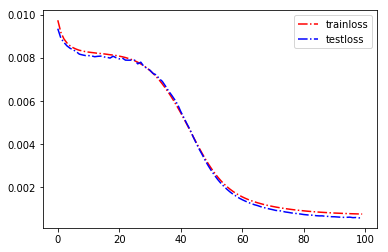

In [8]:
plt.plot(losslist,'r-.',label='trainloss') 
plt.plot(evallosslist,'b-.',label='testloss') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

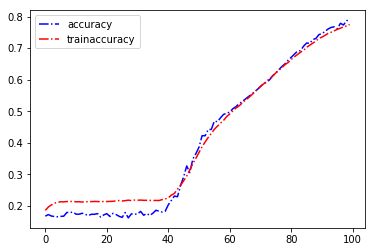

In [9]:
plt.plot(accuracylist,'b-.',label='accuracy')
plt.plot(trainaccuracy,'r-.',label='trainaccuracy') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

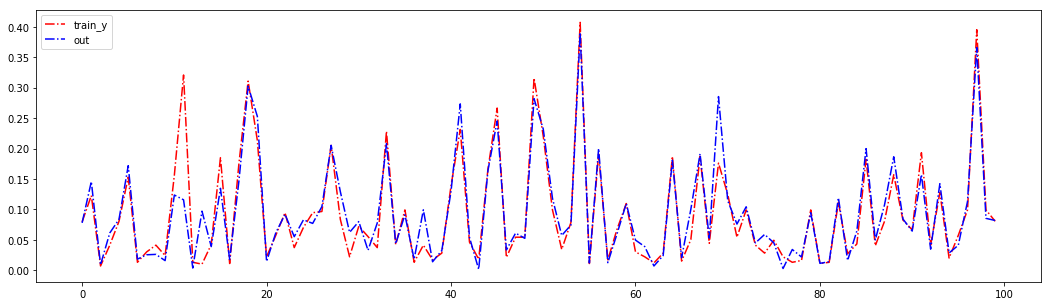

In [10]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

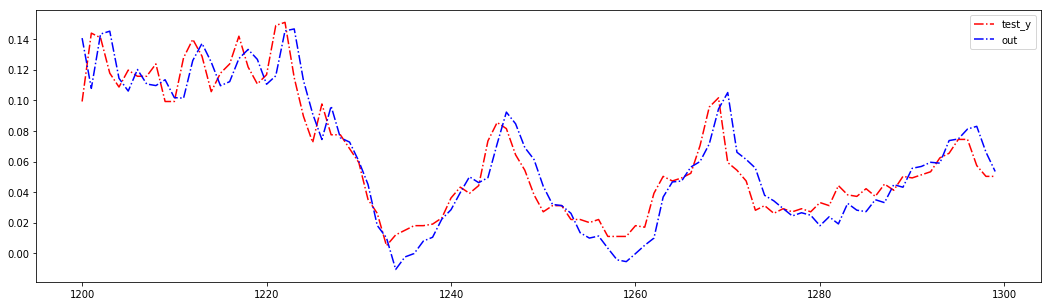

In [11]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,evalout.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

In [12]:
# 保存模型
#torch.save(model.state_dict(), './weatherlstm-0.1-ture-7.23.pth')